In [1]:
import numpy as np
import pandas as pd

if 'ga_assignments' not in globals():
    ga_assignments = {}

for hour in [2, 7, 10]:
    print("=" * 40)
    print(f"Starting solution for HOUR {hour}:")

    tij_path = f"/content/drive/MyDrive/Colab Notebooks/matrix/Tij_matrix_hour_{hour}_critical_points_for_success.csv"
    Tij_df = pd.read_csv(tij_path, index_col=0)
    Tij = Tij_df.values
    num_stations, num_demands = Tij.shape

    station_capacities = [10, 10, 10, 4, 2, 4, 2, 8, 8, 8, 4]
    pop_size = 100
    max_gen = 100
    crossover_rate = 0.9
    mutation_rate = 0.15
    elite_count = 2

    def calculate_station_counts(assignment):
        assignment = np.asarray(assignment).flatten().astype(int)
        return np.bincount(assignment, minlength=num_stations)

    def is_valid(assignment):
        assignment = np.asarray(assignment).flatten().astype(int)
        counts = calculate_station_counts(assignment)
        if np.any(counts > station_capacities):
            return False
        if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
            return False
        return True

    def fitness_function(assignment, alpha=0.8):
        assignment = np.asarray(assignment).flatten().astype(int)
        counts = calculate_station_counts(assignment)
        penalty = 0
        over_mask = counts > station_capacities
        if np.any(over_mask):
            penalty += 10000 * np.sum(counts[over_mask] - np.array(station_capacities)[over_mask])
        if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
            penalty += 100000
        total_time = np.sum(Tij[assignment, np.arange(num_demands)])
        worst_time = np.max(Tij[assignment, np.arange(num_demands)])
        return alpha * total_time + (1 - alpha) * worst_time + penalty

    def repair_assignment(assignment):
        assignment = np.asarray(assignment).flatten().astype(int)
        num_stations = len(station_capacities)
        num_demands = len(assignment)
        counts = np.zeros(num_stations, dtype=int)
        repaired = np.full(num_demands, -1)
        for demand_idx in range(num_demands):
            candidates = [s for s in range(num_stations)
                          if counts[s] < station_capacities[s] and not np.isinf(Tij[s, demand_idx])]
            if candidates:
                best_station = min(candidates, key=lambda s: Tij[s, demand_idx])
                repaired[demand_idx] = best_station
                counts[best_station] += 1
            else:
                min_penalty = float('inf')
                best_station = -1
                for s in range(num_stations):
                    if not np.isinf(Tij[s, demand_idx]):
                        penalty = counts[s] - station_capacities[s]
                        if penalty < min_penalty:
                            min_penalty = penalty
                            best_station = s
                if best_station != -1:
                    repaired[demand_idx] = best_station
                    counts[best_station] += 1
                else:
                    repaired[demand_idx] = np.random.randint(0, num_stations)
        return repaired

    def init_population():
        pop = []
        greedy = np.argmin(Tij, axis=0)
        pop.append(repair_assignment(greedy))
        for _ in range(pop_size - 1):
            random_assign = np.random.randint(0, num_stations, num_demands)
            pop.append(repair_assignment(random_assign))
        return np.array(pop)

    def crossover(parent1, parent2):
        if np.random.rand() < crossover_rate:
            point = np.random.randint(1, num_demands - 1)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return repair_assignment(child1), repair_assignment(child2)
        else:
            return repair_assignment(parent1), repair_assignment(parent2)

    def mutate(individual):
        for i in range(num_demands):
            if np.random.rand() < mutation_rate:
                individual[i] = np.random.randint(0, num_stations)
        return repair_assignment(individual)

    def tournament_selection(pop, fitnesses, k=3):
        selected = np.random.choice(len(pop), k, replace=False)
        best_idx = selected[np.argmin(fitnesses[selected])]
        return pop[best_idx]

    population = init_population()
    fitnesses = np.array([fitness_function(ind) for ind in population])

    best_fitness = np.min(fitnesses)
    best_assignment = population[np.argmin(fitnesses)].copy()
    print(f"Initial Best Fitness: {best_fitness:.2f}")

    for gen in range(max_gen):
        elite_idxs = np.argsort(fitnesses)[:elite_count]
        new_population = [population[i].copy() for i in elite_idxs]

        while len(new_population) < pop_size:
            p1 = tournament_selection(population, fitnesses)
            p2 = tournament_selection(population, fitnesses)
            c1, c2 = crossover(p1, p2)
            new_population.append(mutate(c1))
            if len(new_population) < pop_size:
                new_population.append(mutate(c2))

        population = np.array(new_population)
        fitnesses = np.array([fitness_function(ind) for ind in population])
        gen_best = np.min(fitnesses)
        if gen_best < best_fitness:
            best_fitness = gen_best
            best_assignment = population[np.argmin(fitnesses)].copy()

        if (gen + 1) % 10 == 0 or gen == 0:
            print(f"Generation {gen+1}/{max_gen}, Best Fitness: {best_fitness:.2f}")

    ga_assignments[hour] = best_assignment.copy()

    print("\nGA finished!")
    print(f"Best total travel time: {best_fitness:.2f}")
    station_counts = calculate_station_counts(best_assignment)
    print("\nNumber of demands assigned to each station:")
    for station, count in enumerate(station_counts):
        print(f"Station {station}: {count} demands")
    if is_valid(best_assignment):
        print("\nSolution is valid: All constraints satisfied.")
    else:
        print("\nWARNING: Solution does not fully satisfy constraints.")

    greedy_assignment = np.argmin(Tij, axis=0)
    greedy_cost = np.sum(Tij[greedy_assignment, np.arange(num_demands)])
    print("Greedy total time (unconstrained):", greedy_cost)
    print("GA - Greedy difference:", best_fitness - greedy_cost)
    if greedy_cost > 0 and best_fitness < np.inf:
        percentage = (greedy_cost / best_fitness) * 100
        print(f"GA solution is up to %{percentage:.2f} of greedy optimum.")
        diff = best_fitness - greedy_cost
        print(f"Extra cost: {diff:.2f} (percentage: %{(diff/greedy_cost)*100:.2f})")
    else:
        print("Calculation not possible. The result may be invalid.")


Starting solution for HOUR 2:
Initial Best Fitness: 14312.90
Generation 1/100, Best Fitness: 14312.90
Generation 10/100, Best Fitness: 14312.90
Generation 20/100, Best Fitness: 14312.90
Generation 30/100, Best Fitness: 14312.90
Generation 40/100, Best Fitness: 14312.90
Generation 50/100, Best Fitness: 14312.90
Generation 60/100, Best Fitness: 14312.90
Generation 70/100, Best Fitness: 14312.90
Generation 80/100, Best Fitness: 14312.90
Generation 90/100, Best Fitness: 14312.90
Generation 100/100, Best Fitness: 14312.90

GA finished!
Best total travel time: 14312.90

Number of demands assigned to each station:
Station 0: 1 demands
Station 1: 10 demands
Station 2: 10 demands
Station 3: 4 demands
Station 4: 2 demands
Station 5: 4 demands
Station 6: 2 demands
Station 7: 8 demands
Station 8: 8 demands
Station 9: 8 demands
Station 10: 2 demands

Solution is valid: All constraints satisfied.
Greedy total time (unconstrained): 12128.47675847357
GA - Greedy difference: 2184.426035768938
GA soluti

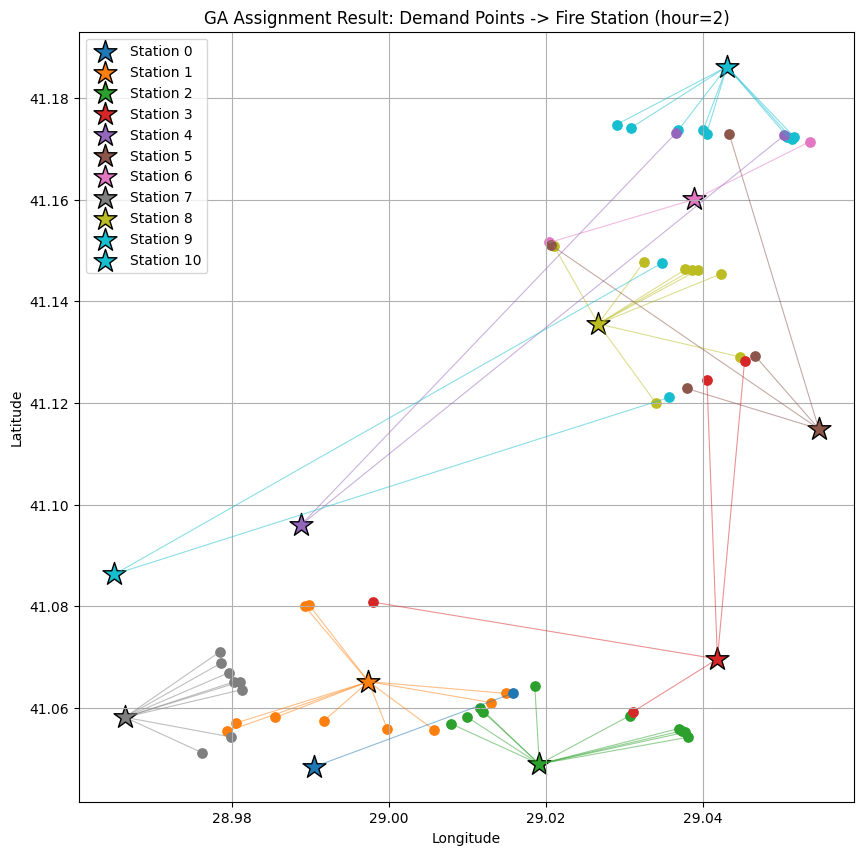

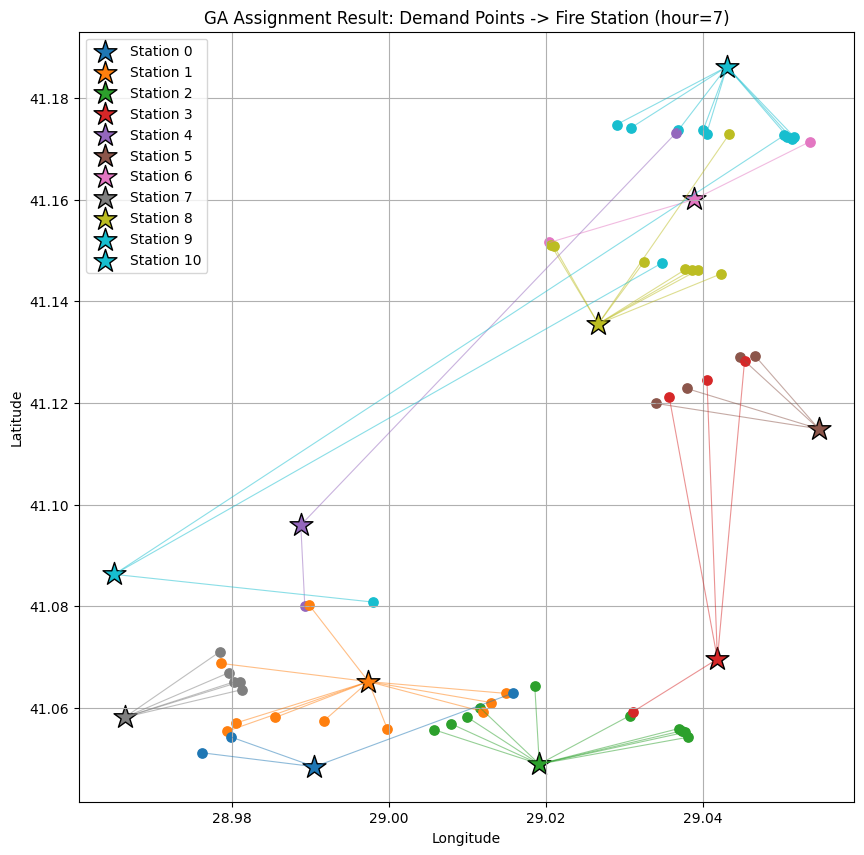

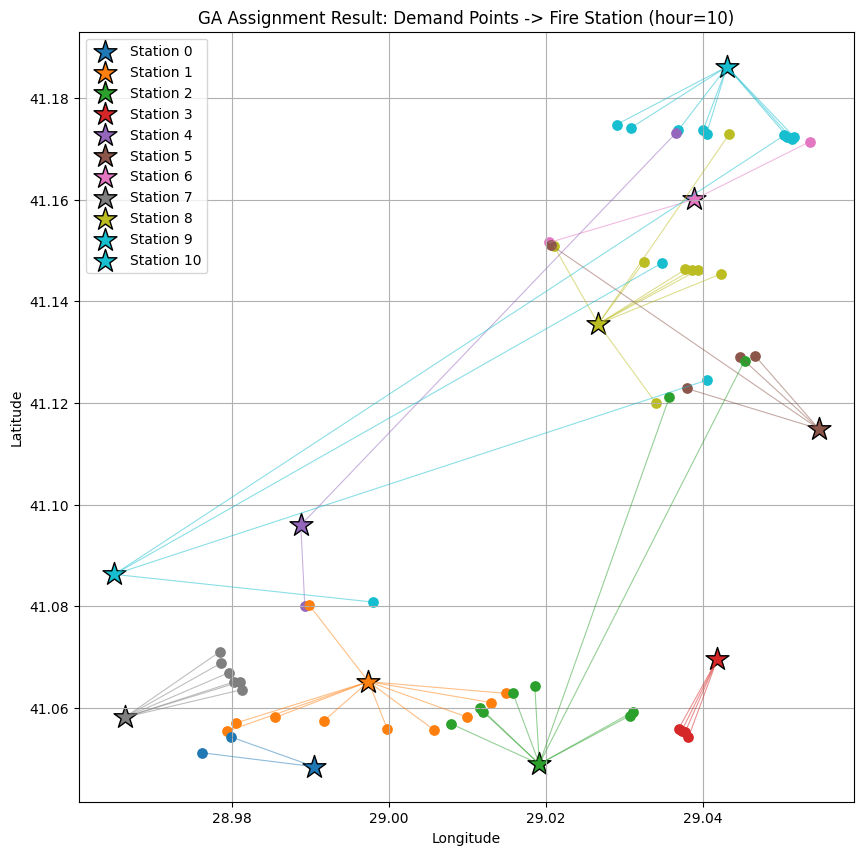

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fire_station_file = '/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv'
demand_file = '/content/drive/MyDrive/Colab Notebooks/final_critical_demand_zones_80_for_success.csv'

fire_station_df = pd.read_csv(fire_station_file)
demand_df = pd.read_csv(demand_file)

fire_station_df.columns = [c.lower().replace(" ", "_") for c in fire_station_df.columns]
demand_df.columns = [c.lower().replace(" ", "_") for c in demand_df.columns]

def find_coord_column(df, prefix_list):
    lat_col = None
    lon_col = None
    for prefix in prefix_list:
        for col in df.columns:
            if 'lat' in col or (prefix in col and 'x' in col):
                lat_col = col
            if 'lon' in col or (prefix in col and 'y' in col):
                lon_col = col
    return lat_col, lon_col

fire_station_lat_col, fire_station_lon_col = find_coord_column(fire_station_df, ['koordinat', 'lat', 'lon'])
demand_lat_col, demand_lon_col = find_coord_column(demand_df, ['lat', 'lon'])

colors = plt.get_cmap('tab10')

for hour in [2, 7, 10]:
    best_assignment = ga_assignments[hour]

    plt.figure(figsize=(10, 10))
    for i, (ilat, ilon) in enumerate(zip(fire_station_df[fire_station_lat_col], fire_station_df[fire_station_lon_col])):
        plt.scatter(ilon, ilat, marker='*', s=300, color=colors(i), edgecolor='k', label=f'Station {i}')

    for j, (dlat, dlon) in enumerate(zip(demand_df[demand_lat_col], demand_df[demand_lon_col])):
        assigned_station = best_assignment[j]
        plt.scatter(dlon, dlat, color=colors(assigned_station), marker='o', s=45)
        plt.plot([fire_station_df[fire_station_lon_col].iloc[assigned_station], dlon],
                 [fire_station_df[fire_station_lat_col].iloc[assigned_station], dlat],
                 color=colors(assigned_station), linewidth=0.8, alpha=0.5)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'GA Assignment Result: Demand Points -> Fire Station (hour={hour})')
    plt.legend()
    plt.grid(True)
    plt.show()


In [3]:
import numpy as np
import pandas as pd

print("=" * 40)
print("Starting solution for STATIC Tij:")

tij_path = "/content/drive/MyDrive/Colab Notebooks/matrix/STATIC_Tij_matrix_80_for_success.csv"
Tij_df = pd.read_csv(tij_path, index_col=0)
Tij = Tij_df.values
num_stations, num_demands = Tij.shape

station_capacities = [10, 10, 10, 4, 2, 4, 2, 8, 8, 8, 4]
pop_size = 100
max_gen = 100
crossover_rate = 0.9
mutation_rate = 0.15
elite_count = 2

def calculate_station_counts(assignment):
    assignment = np.asarray(assignment).flatten().astype(int)
    return np.bincount(assignment, minlength=num_stations)

def is_valid(assignment):
    assignment = np.asarray(assignment).flatten().astype(int)
    counts = calculate_station_counts(assignment)
    if np.any(counts > station_capacities):
        return False
    if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
        return False
    return True

def fitness_function(assignment, alpha=0.8):
    assignment = np.asarray(assignment).flatten().astype(int)
    counts = calculate_station_counts(assignment)
    penalty = 0
    over_mask = counts > station_capacities
    if np.any(over_mask):
        penalty += 10000 * np.sum(counts[over_mask] - np.array(station_capacities)[over_mask])
    if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
        penalty += 100000
    total_time = np.sum(Tij[assignment, np.arange(num_demands)])
    worst_time = np.max(Tij[assignment, np.arange(num_demands)])
    return alpha * total_time + (1 - alpha) * worst_time + penalty

def repair_assignment(assignment):
    assignment = np.asarray(assignment).flatten().astype(int)
    counts = np.zeros(num_stations, dtype=int)
    repaired = np.full(num_demands, -1)
    for demand_idx in range(num_demands):
        candidates = [s for s in range(num_stations)
                      if counts[s] < station_capacities[s] and not np.isinf(Tij[s, demand_idx])]
        if candidates:
            best_station = min(candidates, key=lambda s: Tij[s, demand_idx])
            repaired[demand_idx] = best_station
            counts[best_station] += 1
        else:
            min_penalty = float('inf')
            best_station = -1
            for s in range(num_stations):
                if not np.isinf(Tij[s, demand_idx]):
                    penalty = counts[s] - station_capacities[s]
                    if penalty < min_penalty:
                        min_penalty = penalty
                        best_station = s
            if best_station != -1:
                repaired[demand_idx] = best_station
                counts[best_station] += 1
            else:
                repaired[demand_idx] = np.random.randint(0, num_stations)
    return repaired

def init_population():
    pop = []
    greedy = np.argmin(Tij, axis=0)
    pop.append(repair_assignment(greedy))
    for _ in range(pop_size - 1):
        random_assign = np.random.randint(0, num_stations, num_demands)
        pop.append(repair_assignment(random_assign))
    return np.array(pop)

def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        point = np.random.randint(1, num_demands - 1)
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
        return repair_assignment(child1), repair_assignment(child2)
    else:
        return repair_assignment(parent1), repair_assignment(parent2)

def mutate(individual):
    for i in range(num_demands):
        if np.random.rand() < mutation_rate:
            individual[i] = np.random.randint(0, num_stations)
    return repair_assignment(individual)

def tournament_selection(pop, fitnesses, k=3):
    selected = np.random.choice(len(pop), k, replace=False)
    best_idx = selected[np.argmin(fitnesses[selected])]
    return pop[best_idx]

population = init_population()
fitnesses = np.array([fitness_function(ind) for ind in population])

best_fitness = np.min(fitnesses)
best_assignment = population[np.argmin(fitnesses)].copy()
print(f"Initial Best Fitness: {best_fitness:.2f}")

for gen in range(max_gen):
    elite_idxs = np.argsort(fitnesses)[:elite_count]
    new_population = [population[i].copy() for i in elite_idxs]

    while len(new_population) < pop_size:
        p1 = tournament_selection(population, fitnesses)
        p2 = tournament_selection(population, fitnesses)
        c1, c2 = crossover(p1, p2)
        new_population.append(mutate(c1))
        if len(new_population) < pop_size:
            new_population.append(mutate(c2))

    population = np.array(new_population)
    fitnesses = np.array([fitness_function(ind) for ind in population])
    gen_best = np.min(fitnesses)
    if gen_best < best_fitness:
        best_fitness = gen_best
        best_assignment = population[np.argmin(fitnesses)].copy()

    if (gen + 1) % 10 == 0 or gen == 0:
        print(f"Generation {gen+1}/{max_gen}, Best Fitness: {best_fitness:.2f}")

print("\nGA finished!")
print(f"Best total travel time: {best_fitness:.2f}")
station_counts = calculate_station_counts(best_assignment)
print("\nNumber of demands assigned to each station:")
for station, count in enumerate(station_counts):
    print(f"Station {station}: {count} demands")
if is_valid(best_assignment):
    print("\nSolution is valid: All constraints satisfied.")
else:
    print("\nWARNING: Solution does not fully satisfy constraints.")

greedy_assignment = np.argmin(Tij, axis=0)
greedy_cost = np.sum(Tij[greedy_assignment, np.arange(num_demands)])
print("Greedy total time (unconstrained):", greedy_cost)
print("GA - Greedy difference:", best_fitness - greedy_cost)
if greedy_cost > 0 and best_fitness < np.inf:
    percentage = (greedy_cost / best_fitness) * 100
    print(f"GA solution is up to %{percentage:.2f} of greedy optimum.")
    diff = best_fitness - greedy_cost
    print(f"Extra cost: {diff:.2f} (percentage: %{(diff/greedy_cost)*100:.2f})")
else:
    print("Calculation not possible. The result may be invalid.")


Starting solution for STATIC Tij:
Initial Best Fitness: 9322.03
Generation 1/100, Best Fitness: 9322.03
Generation 10/100, Best Fitness: 9322.03
Generation 20/100, Best Fitness: 9322.03
Generation 30/100, Best Fitness: 9322.03
Generation 40/100, Best Fitness: 9322.03
Generation 50/100, Best Fitness: 9322.03
Generation 60/100, Best Fitness: 9322.03
Generation 70/100, Best Fitness: 9322.03
Generation 80/100, Best Fitness: 9322.03
Generation 90/100, Best Fitness: 9322.03
Generation 100/100, Best Fitness: 9322.03

GA finished!
Best total travel time: 9322.03

Number of demands assigned to each station:
Station 0: 2 demands
Station 1: 10 demands
Station 2: 9 demands
Station 3: 4 demands
Station 4: 2 demands
Station 5: 4 demands
Station 6: 2 demands
Station 7: 6 demands
Station 8: 8 demands
Station 9: 8 demands
Station 10: 4 demands

Solution is valid: All constraints satisfied.
Greedy total time (unconstrained): 7170.538676681921
GA - Greedy difference: 2151.4938215845195
GA solution is up 

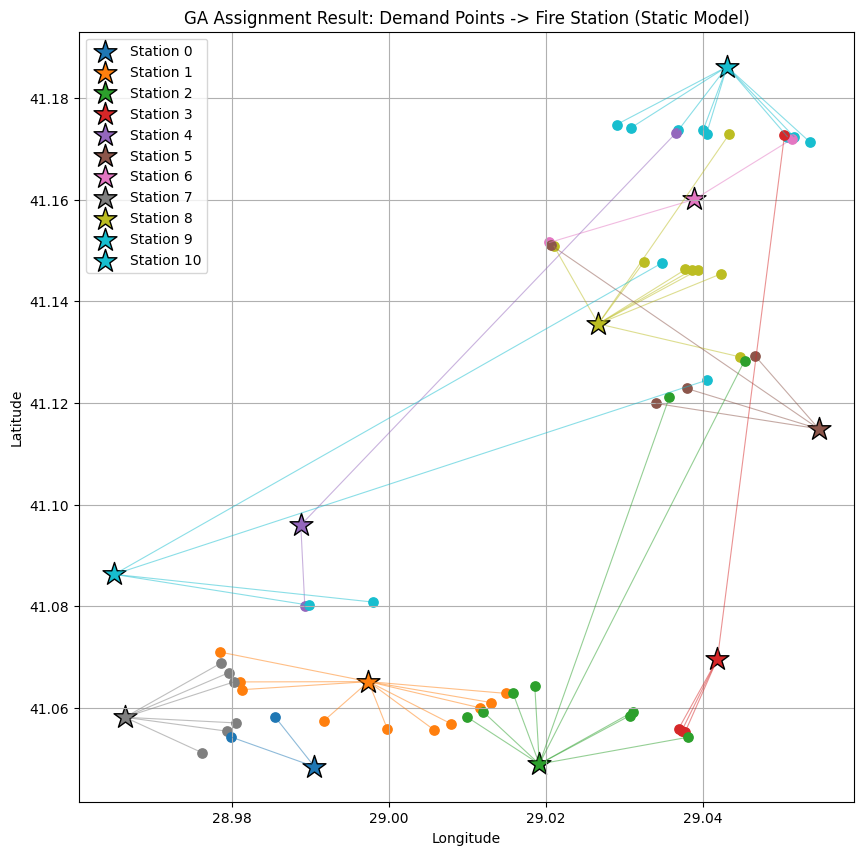

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fire_station_file = '/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv'
demand_file = '/content/drive/MyDrive/Colab Notebooks/final_critical_demand_zones_80_for_success.csv'

fire_station_df = pd.read_csv(fire_station_file)
demand_df = pd.read_csv(demand_file)

fire_station_df.columns = [c.lower().replace(" ", "_") for c in fire_station_df.columns]
demand_df.columns = [c.lower().replace(" ", "_") for c in demand_df.columns]

def find_coord_column(df, prefix_list):
    lat_col = None
    lon_col = None
    for prefix in prefix_list:
        for col in df.columns:
            if 'lat' in col or (prefix in col and 'x' in col):
                lat_col = col
            if 'lon' in col or (prefix in col and 'y' in col):
                lon_col = col
    return lat_col, lon_col

fire_station_lat_col, fire_station_lon_col = find_coord_column(fire_station_df, ['koordinat', 'lat', 'lon'])
demand_lat_col, demand_lon_col = find_coord_column(demand_df, ['lat', 'lon'])

if fire_station_lat_col is None or fire_station_lon_col is None:
    print(f"Fire station file columns: {fire_station_df.columns}")

if demand_lat_col is None or demand_lon_col is None:
    print(f"Demand file columns: {demand_df.columns}")

colors = plt.get_cmap('tab10')
plt.figure(figsize=(10, 10))

for i, (ilat, ilon) in enumerate(zip(fire_station_df[fire_station_lat_col], fire_station_df[fire_station_lon_col])):
    plt.scatter(ilon, ilat, marker='*', s=300, color=colors(i), edgecolor='k', label=f'Station {i}')

for j, (dlat, dlon) in enumerate(zip(demand_df[demand_lat_col], demand_df[demand_lon_col])):
    assigned_station = best_assignment[j]
    plt.scatter(dlon, dlat, color=colors(assigned_station), marker='o', s=45)
    plt.plot([fire_station_df[fire_station_lon_col].iloc[assigned_station], dlon],
             [fire_station_df[fire_station_lat_col].iloc[assigned_station], dlat],
             color=colors(assigned_station), linewidth=0.8, alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GA Assignment Result: Demand Points -> Fire Station (Static Model)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

ga_assignments = {}

for hour in [2, 7, 10]:
    print("=" * 40)
    print(f"Starting solution for HOUR {hour}:")
    tij_path = f"/content/drive/MyDrive/Colab Notebooks/matrix/filter_kmeans80_Tij_matrix_hour_{hour}_yeni.csv"
    Tij_df = pd.read_csv(tij_path, index_col=0)
    Tij = Tij_df.values
    num_stations, num_demands = Tij.shape

    station_capacities = [8, 10, 10, 8, 6, 6, 6, 8, 6, 6, 8]
    pop_size = 100
    max_gen = 100
    crossover_rate = 0.9
    mutation_rate = 0.15
    elite_count = 2

    def calculate_station_counts(assignment):
        assignment = np.asarray(assignment).flatten().astype(int)
        return np.bincount(assignment, minlength=num_stations)

    def is_valid(assignment):
        assignment = np.asarray(assignment).flatten().astype(int)
        counts = calculate_station_counts(assignment)
        if np.any(counts > station_capacities):
            return False
        if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
            return False
        return True

    def fitness_function(assignment, alpha=0.8):
        assignment = np.asarray(assignment).flatten().astype(int)
        counts = calculate_station_counts(assignment)
        penalty = 0
        over_mask = counts > station_capacities
        if np.any(over_mask):
            penalty += 10000 * np.sum(counts[over_mask] - np.array(station_capacities)[over_mask])
        if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
            penalty += 100000
        total_time = np.sum(Tij[assignment, np.arange(num_demands)])
        worst_time = np.max(Tij[assignment, np.arange(num_demands)])
        return alpha * total_time + (1 - alpha) * worst_time + penalty

    def repair_assignment(assignment):
        assignment = np.asarray(assignment).flatten().astype(int)
        counts = np.zeros(num_stations, dtype=int)
        repaired = np.full(num_demands, -1)
        for demand_idx in range(num_demands):
            candidates = [s for s in range(num_stations)
                          if counts[s] < station_capacities[s] and not np.isinf(Tij[s, demand_idx])]
            if candidates:
                best_station = min(candidates, key=lambda s: Tij[s, demand_idx])
                repaired[demand_idx] = best_station
                counts[best_station] += 1
            else:
                min_penalty = float('inf')
                best_station = -1
                for s in range(num_stations):
                    if not np.isinf(Tij[s, demand_idx]):
                        penalty = counts[s] - station_capacities[s]
                        if penalty < min_penalty:
                            min_penalty = penalty
                            best_station = s
                if best_station != -1:
                    repaired[demand_idx] = best_station
                    counts[best_station] += 1
                else:
                    repaired[demand_idx] = np.random.randint(0, num_stations)
        return repaired

    def init_population():
        pop = []
        greedy = np.argmin(Tij, axis=0)
        pop.append(repair_assignment(greedy))
        for _ in range(pop_size - 1):
            random_assign = np.random.randint(0, num_stations, num_demands)
            pop.append(repair_assignment(random_assign))
        return np.array(pop)

    def crossover(parent1, parent2):
        if np.random.rand() < crossover_rate:
            point = np.random.randint(1, num_demands - 1)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return repair_assignment(child1), repair_assignment(child2)
        else:
            return repair_assignment(parent1), repair_assignment(parent2)

    def mutate(individual):
        for i in range(num_demands):
            if np.random.rand() < mutation_rate:
                individual[i] = np.random.randint(0, num_stations)
        return repair_assignment(individual)

    def tournament_selection(pop, fitnesses, k=3):
        selected = np.random.choice(len(pop), k, replace=False)
        best_idx = selected[np.argmin(fitnesses[selected])]
        return pop[best_idx]

    population = init_population()
    fitnesses = np.array([fitness_function(ind) for ind in population])

    best_fitness = np.min(fitnesses)
    best_assignment = population[np.argmin(fitnesses)].copy()
    print(f"Initial Best Fitness: {best_fitness:.2f}")

    for gen in range(max_gen):
        elite_idxs = np.argsort(fitnesses)[:elite_count]
        new_population = [population[i].copy() for i in elite_idxs]

        while len(new_population) < pop_size:
            p1 = tournament_selection(population, fitnesses)
            p2 = tournament_selection(population, fitnesses)
            c1, c2 = crossover(p1, p2)
            new_population.append(mutate(c1))
            if len(new_population) < pop_size:
                new_population.append(mutate(c2))

        population = np.array(new_population)
        fitnesses = np.array([fitness_function(ind) for ind in population])
        gen_best = np.min(fitnesses)
        if gen_best < best_fitness:
            best_fitness = gen_best
            best_assignment = population[np.argmin(fitnesses)].copy()

        if (gen + 1) % 10 == 0 or gen == 0:
            print(f"Generation {gen+1}/{max_gen}, Best Fitness: {best_fitness:.2f}")

    ga_assignments[hour] = best_assignment.copy()


    print("\nGA finished!")
    print(f"Best total travel time: {best_fitness:.2f}")
    station_counts = calculate_station_counts(best_assignment)
    print("\nNumber of demands assigned to each station:")
    for station, count in enumerate(station_counts):
        print(f"Station {station}: {count} demands")
    if is_valid(best_assignment):
        print("\nSolution is valid: All constraints satisfied.")
    else:
        print("\nWARNING: Solution does not fully satisfy constraints.")

    greedy_assignment = np.argmin(Tij, axis=0)
    greedy_cost = np.sum(Tij[greedy_assignment, np.arange(num_demands)])
    print("Greedy total time (unconstrained):", greedy_cost)
    print("GA - Greedy difference:", best_fitness - greedy_cost)
    if greedy_cost > 0 and best_fitness < np.inf:
        percentage = (greedy_cost / best_fitness) * 100
        print(f"GA solution is up to %{percentage:.2f} of greedy optimum.")
        diff = best_fitness - greedy_cost
        print(f"Extra cost: {diff:.2f} (percentage: %{(diff/greedy_cost)*100:.2f})")
    else:
        print("Calculation not possible. The result may be invalid.")


Starting solution for HOUR 2:
Initial Best Fitness: 43556.57
Generation 1/100, Best Fitness: 43556.57
Generation 10/100, Best Fitness: 43556.57
Generation 20/100, Best Fitness: 43556.57
Generation 30/100, Best Fitness: 43556.57
Generation 40/100, Best Fitness: 43556.57
Generation 50/100, Best Fitness: 43556.57
Generation 60/100, Best Fitness: 43556.57
Generation 70/100, Best Fitness: 43556.57
Generation 80/100, Best Fitness: 43556.57
Generation 90/100, Best Fitness: 43556.57
Generation 100/100, Best Fitness: 43556.57

GA finished!
Best total travel time: 43556.57

Number of demands assigned to each station:
Station 0: 6 demands
Station 1: 10 demands
Station 2: 10 demands
Station 3: 8 demands
Station 4: 6 demands
Station 5: 6 demands
Station 6: 6 demands
Station 7: 8 demands
Station 8: 6 demands
Station 9: 6 demands
Station 10: 8 demands

Solution is valid: All constraints satisfied.
Greedy total time (unconstrained): 24150.51638431735
GA - Greedy difference: 19406.049579190752
GA solut

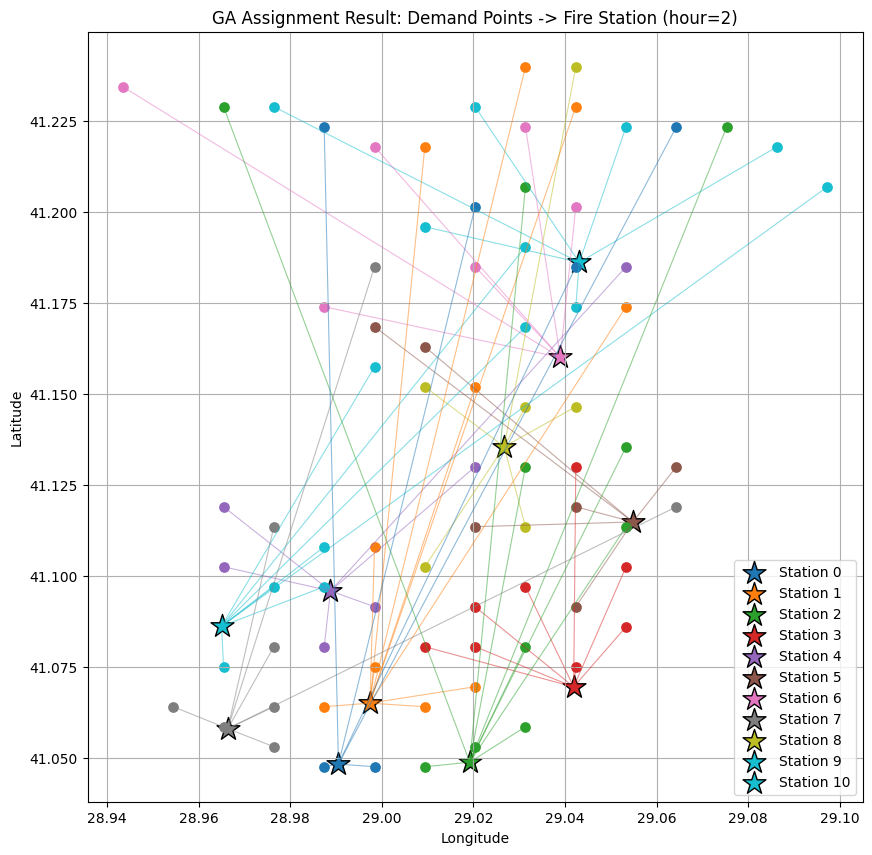

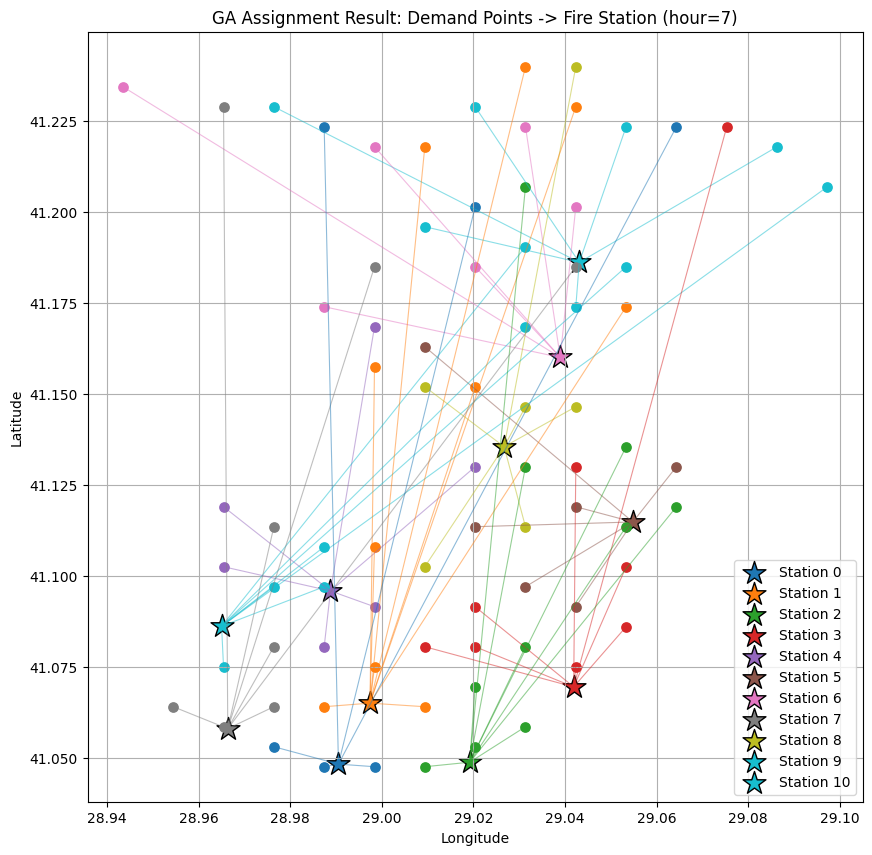

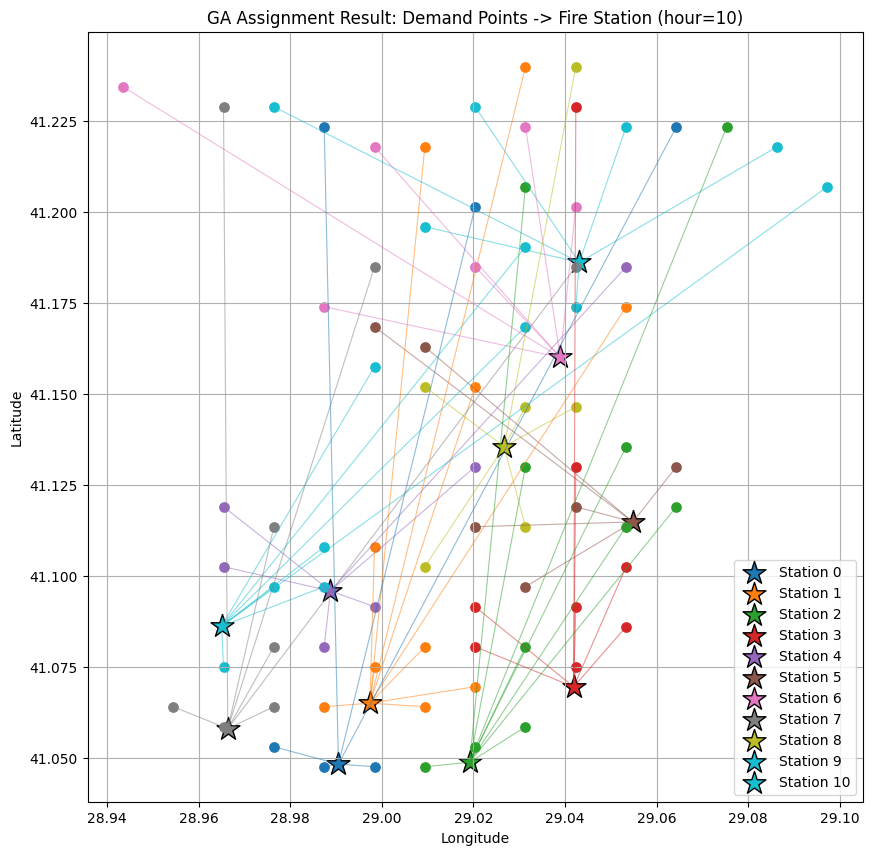

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fire_station_file = '/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv'
demand_file = '/content/drive/MyDrive/Colab Notebooks/selected_80_demand_zones.csv'

fire_station_df = pd.read_csv(fire_station_file)
demand_df = pd.read_csv(demand_file)

fire_station_df.columns = [c.lower().replace(" ", "_") for c in fire_station_df.columns]
demand_df.columns = [c.lower().replace(" ", "_") for c in demand_df.columns]

def find_coord_column(df, lat_candidates, lon_candidates):
    lat_col, lon_col = None, None
    for col in df.columns:
        if any(cand in col for cand in lat_candidates): lat_col = col
        if any(cand in col for cand in lon_candidates): lon_col = col
    return lat_col, lon_col

fire_station_lat_col, fire_station_lon_col = find_coord_column(fire_station_df, ['lat', 'x'], ['lon', 'y'])
demand_lat_col, demand_lon_col = find_coord_column(demand_df, ['lat', 'x'], ['lon', 'y'])

colors = plt.get_cmap('tab10')

for hour in [2, 7, 10]:
    plt.figure(figsize=(10, 10))

    for i, (ilat, ilon) in enumerate(zip(fire_station_df[fire_station_lat_col], fire_station_df[fire_station_lon_col])):
        plt.scatter(ilon, ilat, marker='*', s=300, color=colors(i), edgecolor='k', label=f'Station {i}')

    for j, (dlat, dlon) in enumerate(zip(demand_df[demand_lat_col], demand_df[demand_lon_col])):
        assigned_station = ga_assignments[hour][j]
        plt.scatter(dlon, dlat, color=colors(assigned_station), marker='o', s=45)
        plt.plot([fire_station_df[fire_station_lon_col].iloc[assigned_station], dlon],
                 [fire_station_df[fire_station_lat_col].iloc[assigned_station], dlat],
                 color=colors(assigned_station), linewidth=0.8, alpha=0.5)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'GA Assignment Result: Demand Points -> Fire Station (hour={hour})')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
import numpy as np
import pandas as pd

tij_path = '/content/drive/MyDrive/Colab Notebooks/matrix/STATIC_kmeans80_Tij_matrix.csv'
Tij_df = pd.read_csv(tij_path, index_col=0)
Tij = Tij_df.values
num_stations, num_demands = Tij.shape

station_capacities = [8, 10, 10, 8, 6, 6, 6, 8, 6, 6, 8]
pop_size = 100
max_gen = 100
crossover_rate = 0.9
mutation_rate = 0.15
elite_count = 2

def calculate_station_counts(assignment):
    assignment = np.asarray(assignment).flatten().astype(int)
    return np.bincount(assignment, minlength=num_stations)

def is_valid(assignment):
    assignment = np.asarray(assignment).flatten().astype(int)
    counts = calculate_station_counts(assignment)
    if np.any(counts > station_capacities):
        return False
    if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
        return False
    return True

def fitness_function(assignment, alpha=0.8):
    assignment = np.asarray(assignment).flatten().astype(int)
    counts = calculate_station_counts(assignment)
    penalty = 0
    over_mask = counts > station_capacities
    if np.any(over_mask):
        penalty += 10000 * np.sum(counts[over_mask] - np.array(station_capacities)[over_mask])
    if np.any(np.isinf(Tij[assignment, np.arange(num_demands)])):
        penalty += 100000
    total_time = np.sum(Tij[assignment, np.arange(num_demands)])
    worst_time = np.max(Tij[assignment, np.arange(num_demands)])
    return alpha * total_time + (1 - alpha) * worst_time + penalty

def repair_assignment(assignment):
    assignment = np.asarray(assignment).flatten().astype(int)
    counts = np.zeros(num_stations, dtype=int)
    repaired = np.full(num_demands, -1)
    for demand_idx in range(num_demands):
        candidates = [s for s in range(num_stations)
                      if counts[s] < station_capacities[s] and not np.isinf(Tij[s, demand_idx])]
        if candidates:
            best_station = min(candidates, key=lambda s: Tij[s, demand_idx])
            repaired[demand_idx] = best_station
            counts[best_station] += 1
        else:
            min_penalty = float('inf')
            best_station = -1
            for s in range(num_stations):
                if not np.isinf(Tij[s, demand_idx]):
                    penalty = counts[s] - station_capacities[s]
                    if penalty < min_penalty:
                        min_penalty = penalty
                        best_station = s
            if best_station != -1:
                repaired[demand_idx] = best_station
                counts[best_station] += 1
            else:
                repaired[demand_idx] = np.random.randint(0, num_stations)
    return repaired

def init_population():
    pop = []
    greedy = np.argmin(Tij, axis=0)
    pop.append(repair_assignment(greedy))
    for _ in range(pop_size - 1):
        random_assign = np.random.randint(0, num_stations, num_demands)
        pop.append(repair_assignment(random_assign))
    return np.array(pop)

def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        point = np.random.randint(1, num_demands - 1)
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
        return repair_assignment(child1), repair_assignment(child2)
    else:
        return repair_assignment(parent1), repair_assignment(parent2)

def mutate(individual):
    for i in range(num_demands):
        if np.random.rand() < mutation_rate:
            individual[i] = np.random.randint(0, num_stations)
    return repair_assignment(individual)

def tournament_selection(pop, fitnesses, k=3):
    selected = np.random.choice(len(pop), k, replace=False)
    best_idx = selected[np.argmin(fitnesses[selected])]
    return pop[best_idx]

population = init_population()
fitnesses = np.array([fitness_function(ind) for ind in population])

best_fitness = np.min(fitnesses)
best_assignment = population[np.argmin(fitnesses)].copy()
print(f"Initial Best Fitness: {best_fitness:.2f}")

for gen in range(max_gen):
    elite_idxs = np.argsort(fitnesses)[:elite_count]
    new_population = [population[i].copy() for i in elite_idxs]

    while len(new_population) < pop_size:
        p1 = tournament_selection(population, fitnesses)
        p2 = tournament_selection(population, fitnesses)
        c1, c2 = crossover(p1, p2)
        new_population.append(mutate(c1))
        if len(new_population) < pop_size:
            new_population.append(mutate(c2))

    population = np.array(new_population)
    fitnesses = np.array([fitness_function(ind) for ind in population])
    gen_best = np.min(fitnesses)
    if gen_best < best_fitness:
        best_fitness = gen_best
        best_assignment = population[np.argmin(fitnesses)].copy()

    if (gen + 1) % 10 == 0 or gen == 0:
        print(f"Generation {gen+1}/{max_gen}, Best Fitness: {best_fitness:.2f}")

print("\nGA finished!")
print(f"Best total travel time: {best_fitness:.2f}")
station_counts = calculate_station_counts(best_assignment)
print("\nNumber of demands assigned to each station:")
for station, count in enumerate(station_counts):
    print(f"Station {station}: {count} demands")
if is_valid(best_assignment):
    print("\nSolution is valid: All constraints satisfied.")
else:
    print("\nWARNING: Solution does not fully satisfy constraints.")

greedy_assignment = np.argmin(Tij, axis=0)
greedy_cost = np.sum(Tij[greedy_assignment, np.arange(num_demands)])
print("Greedy total time (unconstrained):", greedy_cost)
print("GA - Greedy difference:", best_fitness - greedy_cost)
if greedy_cost > 0 and best_fitness < np.inf:
    percentage = (greedy_cost / best_fitness) * 100
    print(f"GA solution is up to %{percentage:.2f} of greedy optimum.")
    diff = best_fitness - greedy_cost
    print(f"Extra cost: {diff:.2f} (percentage: %{(diff/greedy_cost)*100:.2f})")
else:
    print("Calculation not possible. The result may be invalid.")


Initial Best Fitness: 31935.51
Generation 1/100, Best Fitness: 31935.51
Generation 10/100, Best Fitness: 31935.51
Generation 20/100, Best Fitness: 31935.51
Generation 30/100, Best Fitness: 31935.51
Generation 40/100, Best Fitness: 31935.51
Generation 50/100, Best Fitness: 31935.51
Generation 60/100, Best Fitness: 31935.51
Generation 70/100, Best Fitness: 31935.51
Generation 80/100, Best Fitness: 31935.51
Generation 90/100, Best Fitness: 31935.51
Generation 100/100, Best Fitness: 31935.51

GA finished!
Best total travel time: 31935.51

Number of demands assigned to each station:
Station 0: 6 demands
Station 1: 10 demands
Station 2: 10 demands
Station 3: 8 demands
Station 4: 6 demands
Station 5: 6 demands
Station 6: 6 demands
Station 7: 8 demands
Station 8: 6 demands
Station 9: 6 demands
Station 10: 8 demands

Solution is valid: All constraints satisfied.
Greedy total time (unconstrained): 15650.893828297982
GA - Greedy difference: 16284.618255761843
GA solution is up to %49.01 of greedy

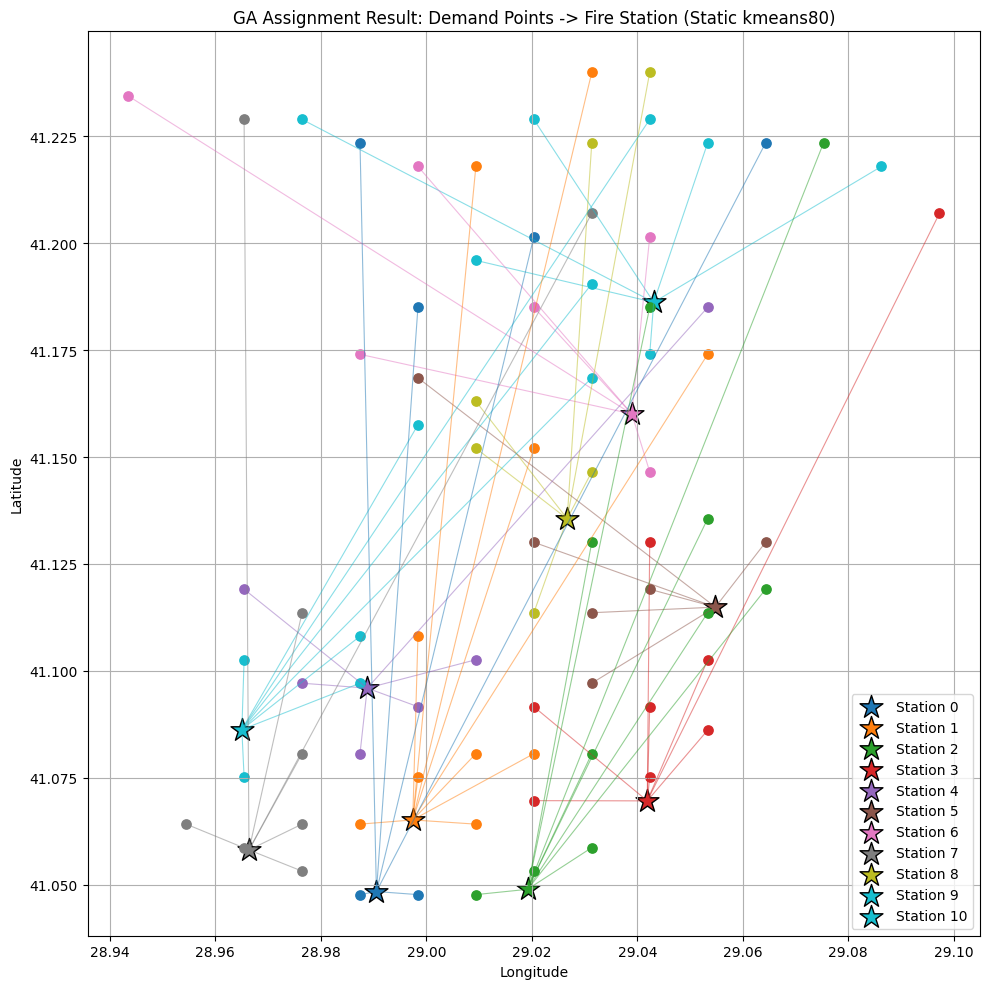

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fire_station_file = '/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv'
demand_file = '/content/drive/MyDrive/Colab Notebooks/selected_80_demand_zones.csv'

fire_station_df = pd.read_csv(fire_station_file)
demand_df = pd.read_csv(demand_file)

fire_station_df.columns = [c.lower().replace(" ", "_") for c in fire_station_df.columns]
demand_df.columns = [c.lower().replace(" ", "_") for c in demand_df.columns]

def find_coord_column(df, lat_candidates, lon_candidates):
    lat_col, lon_col = None, None
    for col in df.columns:
        if any(cand in col for cand in lat_candidates): lat_col = col
        if any(cand in col for cand in lon_candidates): lon_col = col
    return lat_col, lon_col

fire_station_lat_col, fire_station_lon_col = find_coord_column(fire_station_df, ['lat', 'x'], ['lon', 'y'])
demand_lat_col, demand_lon_col = find_coord_column(demand_df, ['lat', 'x'], ['lon', 'y'])

colors = plt.get_cmap('tab10')

plt.figure(figsize=(10, 10))

for i, (ilat, ilon) in enumerate(zip(fire_station_df[fire_station_lat_col], fire_station_df[fire_station_lon_col])):
    plt.scatter(ilon, ilat, marker='*', s=300, color=colors(i), edgecolor='k', label=f'Station {i}')

for j, (dlat, dlon) in enumerate(zip(demand_df[demand_lat_col], demand_df[demand_lon_col])):
    assigned_station = best_assignment[j]
    plt.scatter(dlon, dlat, color=colors(assigned_station), marker='o', s=45)
    plt.plot([fire_station_df[fire_station_lon_col].iloc[assigned_station], dlon],
             [fire_station_df[fire_station_lat_col].iloc[assigned_station], dlat],
             color=colors(assigned_station), linewidth=0.8, alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GA Assignment Result: Demand Points -> Fire Station (Static kmeans80)')
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()
